In [3]:
#Standard functions
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time 
import warnings
warnings.filterwarnings('ignore')

#Sklearn / ML functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,minmax_scale
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error,precision_score,recall_score, roc_auc_score,accuracy_score,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA, NMF
import xgboost as xgb

# TensorFlow / Keras functions
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import set_random_seed,to_categorical
from tensorflow.keras.datasets import cifar10



#### 1) Objective

The objective is to classify between a car or truck give an image of a car or truck. In this project, I used principal components to computationally enable using LDA, Random Forest, and Gradient Boosted models. Afterwards, I compared the results to a CNN model with multiple layers.

In [4]:
#Load the Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Index the train and test sets for cars and trucks
index_train = np.where((y_train == 1) | (y_train == 9))[0]
index_test = np.where((y_test == 1) | (y_test == 9))[0]

# Create training, validation, and test sets
X_train,X_test,y_train,y_test = X_train[index_train],X_test[index_test],y_train[index_train],y_test[index_test]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, stratify=y_train, random_state=4)

# Gather the index in the training and test data for car and truck
index_train_car = np.where((y_train == 1))[0]
index_train_truck = np.where((y_train == 9))[0]
index_test_car = np.where((y_test == 1))[0]
index_test_truck = np.where((y_test == 9))[0]

# Examine the shape of the training, validation, and test sets
print('Shape of X_train:',X_train.shape)
print('Shape of X_valid:',X_valid.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of y_valid:',y_valid.shape)
print('Shape of y_test:',y_test.shape)


Shape of X_train: (8000, 32, 32, 3)
Shape of X_valid: (2000, 32, 32, 3)
Shape of X_test: (2000, 32, 32, 3)
Shape of y_train: (8000, 1)
Shape of y_valid: (2000, 1)
Shape of y_test: (2000, 1)


#### 2) EDA




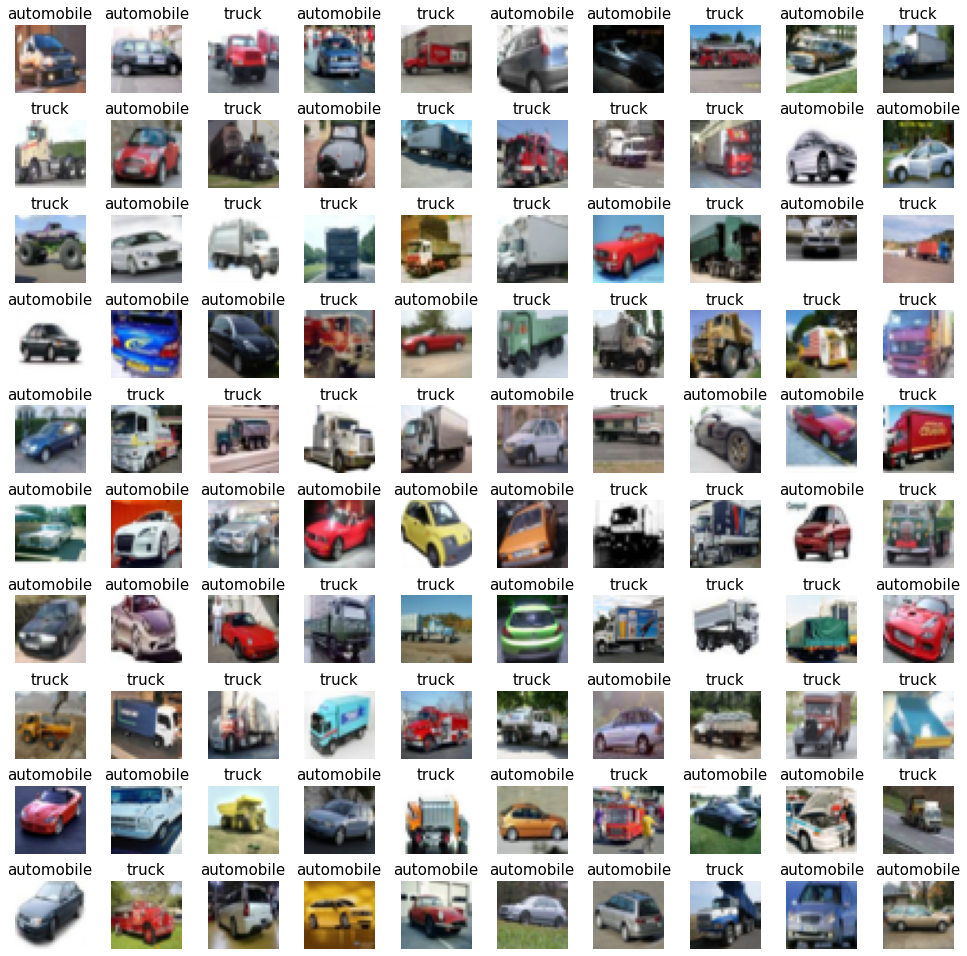

In [5]:
# Plot 100 observations and hypothesize what features or methods might be useful
W_grid = 10
L_grid = 10
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog','horse', 'ship', 'truck']
fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel()
n_train = len(X_train)
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_train)
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 15)
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

Below, I visualized the mean value per pixel for cars and trucks. Cars and trucks have extremely similar mean values by each pixel, which probably will lead to less than ideal results later for stock models. Some features of trucks that might be useful to distinguish them from cars might be the height of their car body and the front.

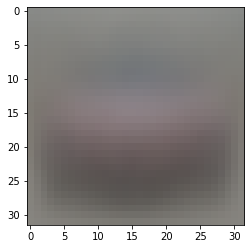

In [6]:
# Average value per pixel for cars
plt.imshow(X_train[index_train_car].mean(axis=0).round(0).astype('int'))

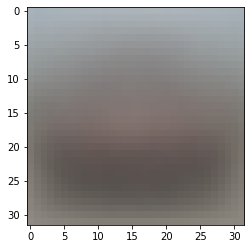

In [7]:
# Average value per pixel for trucks
plt.imshow(X_train[index_train_truck].mean(axis=0).round(0).astype('int'))

#### 3) Principal Component Analysis

In [64]:
# Copied of unscaled training data
X_train_car_unscaled,X_train_truck_unscaled= X_train[index_train_car].reshape(4000,-1),X_train[index_train_truck].reshape(4000,-1)
X_train_unscaled = X_train
X_test_unscaled = X_test

# Scaled the training, validation, and test sets
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train.reshape(8000,-1))
y_train = (y_scaler.fit_transform(y_train.reshape(8000,-1)))

X_valid = X_scaler.transform(X_valid.reshape(2000,-1))
y_valid = (y_scaler.transform(y_valid.reshape(2000,-1)))

X_test = X_scaler.transform(X_test.reshape(2000,-1))
y_test = (y_scaler.transform(y_test.reshape(2000,-1)))

# Scaled training data filtered for just cars/trucks
X_train_car_scaled,X_train_truck_scaled=X_train[index_train_car],X_train[index_train_truck]

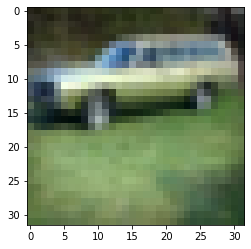

In [65]:
# Example scaled image
plt.imshow(minmax_scale(X_train_car_scaled[0], feature_range=(0,255), axis=0).astype('int').reshape(32,32,3))

For both the car and truck PCA, we used scree plots to examine the best number of components to use. It just so happened that both of them worked well with ~30 components.

#### Car and Truck PCA

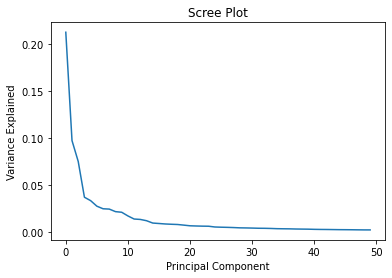

In [66]:
#Car PCA with 50 components
pca=PCA(n_components=50)
pca.fit(X_train)

PC_values = np.arange(pca.n_components_)
plt.plot(PC_values, pca.explained_variance_ratio_)

plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#### Car PCA

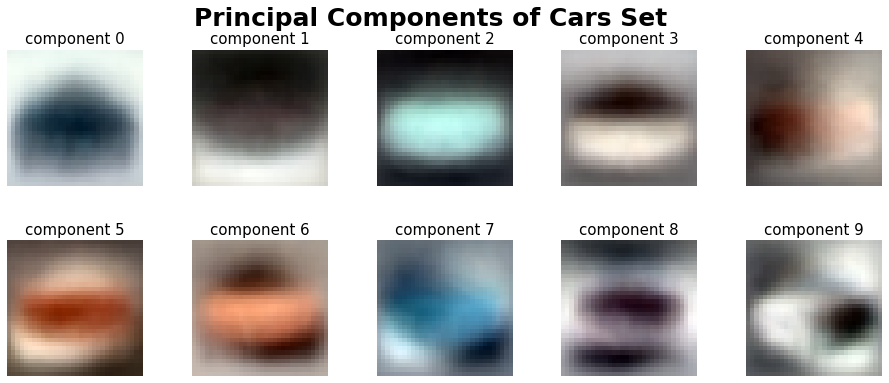

In [67]:
pca1=PCA(n_components=30)
pca1.fit(X_train_car_scaled)

fig, axes = plt.subplots(2, 5, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(minmax_scale(pca1.components_[i], feature_range=(0,255), axis=0).astype('int').reshape(32,32,3))
    axes[i].set_title('component {}'.format(i), fontsize = 15)
    axes[i].axis('off')
    fig.suptitle('Principal Components of Cars Set',fontweight ="bold",fontsize = 25)
plt.subplots_adjust(hspace=0.4)

#### Reconstruction Using PCA

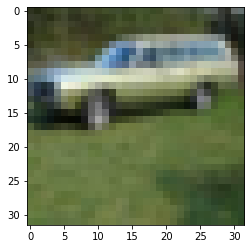

In [68]:
# Original image
plt.imshow(X_train_unscaled[0])

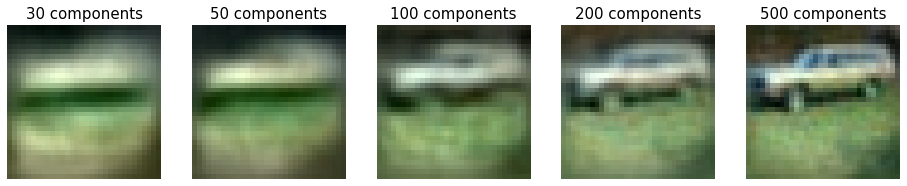

In [69]:
# Reconstructed image
fig, axes = plt.subplots(1, 5, figsize = (16,3))
axes = axes.ravel()
n_components=[30,50,100,200,500]
for i in range(5):
    pca11=PCA(n_components=n_components[i])
    pca11.fit(X_train_car_scaled)
    PCs = pca11.transform(X_train_car_scaled)
    X_recon = pca11.inverse_transform(PCs)
    axes[i].imshow(minmax_scale(X_recon[0], feature_range=(0,255), axis=0).astype('int').reshape(32,32,3))
    axes[i].set_title('{} components'.format(n_components[i]), fontsize = 15)
    axes[i].axis('off')
    #fig.suptitle('Reconstruction Using PCA',fontweight ="bold",fontsize = 25)
plt.subplots_adjust(hspace=0.1)

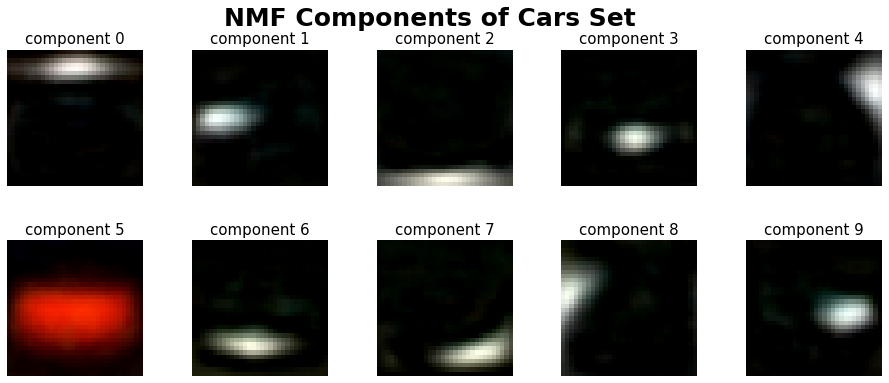

In [70]:
nmf1=NMF(n_components=30)
nmf1.fit(X_train_car_unscaled)

fig, axes = plt.subplots(2, 5, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(minmax_scale(nmf1.components_[i], feature_range=(0,255),axis=0).astype('int').reshape(32,32,3))
    axes[i].set_title('component {}'.format(i), fontsize = 15)
    axes[i].axis('off')
    fig.suptitle('NMF Components of Cars Set',fontweight ="bold",fontsize = 25)
plt.subplots_adjust(hspace=0.4)

#### Truck PCA

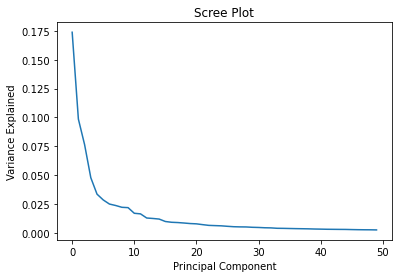

In [16]:
pca2=PCA(n_components=50)
pca2.fit(X_train_truck_scaled)

PC_values = np.arange(pca2.n_components_)
plt.plot(PC_values, pca2.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

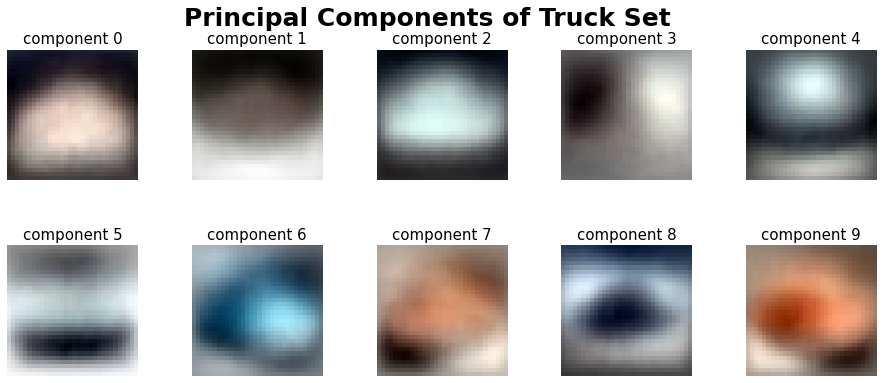

In [72]:
pca2=PCA(n_components=30)
pca2.fit(X_train_truck_scaled)

fig, axes = plt.subplots(2, 5, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(minmax_scale(pca2.components_[i], feature_range=(0,255),axis=0).astype('int').reshape(32,32,3))
    axes[i].set_title('component {}'.format(i), fontsize = 15)
    axes[i].axis('off')
    fig.suptitle('Principal Components of Truck Set',fontweight ="bold",fontsize = 25)
plt.subplots_adjust(hspace=0.5)

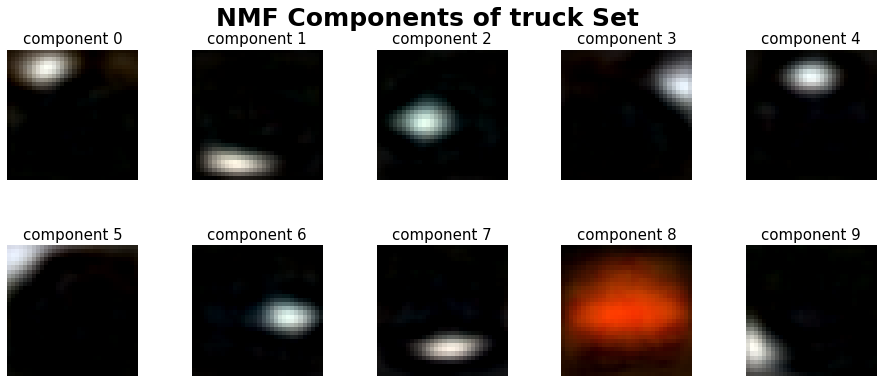

In [73]:
nmf2=NMF(n_components=30)
nmf2.fit(X_train_truck_unscaled)

fig, axes = plt.subplots(2, 5, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow(minmax_scale(nmf2.components_[i], feature_range=(0,255),axis=0).astype('int').reshape(32,32,3))
    axes[i].set_title('component {}'.format(i), fontsize = 15)
    axes[i].axis('off')
    fig.suptitle('NMF Components of truck Set',fontweight ="bold",fontsize = 25)
plt.subplots_adjust(hspace=0.5)

#### 4) Linear Discriminant Analysis

In this section, we'll examine the cost versus performance balance for two LDA models. One will have principal components while the other no transformations. The LDA model with no principal components overfit the training set and performed poorly on the test set. The LDA model with principal components was more consistent from training to test scores. But overall, the simple LDA model didn't perform too well.

In [79]:
# LDA (no principal components)
start = time.time()
lda2=LDA().fit(X_train.reshape(8000,-1),y_train)

preds_pca_train2 = lda2.predict(X_train_unscaled.reshape(8000,-1))
preds_pca_test2 = lda2.predict(X_test_unscaled.reshape(2000,-1))

end = time.time()
time_cost = end-start

print('Accuracy for training set is',accuracy_score(y_train, preds_pca_train2).round(3))
print('Precision for training set is',precision_score(y_train, preds_pca_train2).round(3))
print('Recall for training set is',recall_score(y_train, preds_pca_train2).round(3))
print('\n')
print('Accuracy for test set is',accuracy_score(y_test, preds_pca_test2).round(3))
print('Precision for test set is',precision_score(y_test, preds_pca_test2).round(3))
print('Recall for test set is',recall_score(y_test, preds_pca_test2).round(3))
print('\n')
print('Time cost:',round(time_cost,3),'sec')

Accuracy for training set is 0.78
Precision for training set is 0.701
Recall for training set is 0.978


Accuracy for test set is 0.617
Precision for test set is 0.584
Recall for test set is 0.813


Time cost: 9.227 sec


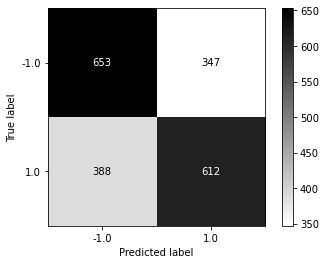

In [75]:
plot_confusion_matrix(lda2,X_test.reshape(2000,-1),y_test,cmap=plt.cm.binary)

In [80]:
# LDA principal components
start = time.time()
pca3=PCA(n_components=30).fit(X_train)

X_train_pca = pca3.transform(X_train)
X_test_pca = pca3.transform(X_test)

lda1=LDA()
lda1.fit(X_train_pca,y_train)

preds_pca_train1 = lda1.predict(X_train_pca)
preds_pca_test1 = lda1.predict(X_test_pca)

end = time.time()
time_cost = end-start

print('Accuracy for training set is',accuracy_score(y_train, preds_pca_train1).round(3))
print('Precision for training set is',precision_score(y_train, preds_pca_train1).round(3))
print('Recall for training set is',recall_score(y_train, preds_pca_train1).round(3))
print('\n')
print('Accuracy for test set is',accuracy_score(y_test, preds_pca_test1).round(3))
print('Precision for test set is',precision_score(y_test, preds_pca_test1).round(3))
print('Recall for test set is',recall_score(y_test, preds_pca_test1).round(3))
print('\n')
print('Time cost:',round(time_cost,3),'sec')

Accuracy for training set is 0.677
Precision for training set is 0.672
Recall for training set is 0.691


Accuracy for test set is 0.689
Precision for test set is 0.685
Recall for test set is 0.701


Time cost: 0.558 sec


In [22]:
preds_pca_train1_bool = (preds_pca_train1.reshape(-1,1)==y_train)

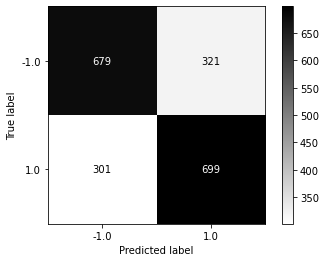

In [23]:
plot_confusion_matrix(lda1,X_test_pca,y_test,cmap=plt.cm.binary)

#### 5a) Random Forest

In [25]:
# Initiate a Random Forest Classifier
rf = RandomForestClassifier(max_depth=1,n_estimators=100)
rf.fit(X_train,y_train)

# Predict on the training set
rf_preds_train = rf.predict(X_train)
rf_preds_train_probs = rf.predict_proba(X_train)

# Precision, recall, and roc auc on training set
rf_accuracy_train = accuracy_score(y_train,rf_preds_train)
rf_precision_train = precision_score(y_train,rf_preds_train)
rf_recall_train = recall_score(y_train,rf_preds_train)
rf_roc_auc_train = roc_auc_score(y_train,rf_preds_train_probs[:,1])

# Predict on the test set
rf_preds_test = rf.predict(X_test)
rf_preds_test_probs = rf.predict_proba(X_test)

# Precision, recall, and roc auc on test set
rf_accuracy_test = accuracy_score(y_test,rf_preds_test)
rf_precision_test = precision_score(y_test,rf_preds_test)
rf_recall_test = recall_score(y_test,rf_preds_test)
rf_roc_auc_test = roc_auc_score(y_test,rf_preds_test_probs[:,1])

# Print results
print("Random Forest Train Accuracy Score: ", round(rf_accuracy_train,2))
print("Random Forest Train Precision Score: ", round(rf_precision_train,2))
print("Random Forest Train Recall Score: ", round(rf_recall_train,2))
print("Random Forest Train AUC ROC Score: ", round(rf_roc_auc_train,2))
print('\n')
print("Random Forest Test Accuracy Score: ", round(rf_accuracy_test,2))
print("Random Forest Test Precision Score: ", round(rf_precision_test,2))
print("Random Forest Test Recall Score: ", round(rf_recall_test,2))
print("Random Forest Test AUC ROC Score: ", round(rf_roc_auc_test,2))
print('\n')

Random Forest Train Accuracy Score:  0.65
Random Forest Train Precision Score:  0.64
Random Forest Train Recall Score:  0.69
Random Forest Train AUC ROC Score:  0.68


Random Forest Test Accuracy Score:  0.66
Random Forest Test Precision Score:  0.65
Random Forest Test Recall Score:  0.69
Random Forest Test AUC ROC Score:  0.68




#### 5b) Random Forest with GridSearchCV

A problem with all of the top five predictors was that the model overfit the training set. If I did the gridsearch again, I would decrease compleixity to decrease the overfitting, but not for now because the gridsearch can take over a whole day to run.

In [28]:
#rf_parameters = {
#    'max_depth':range(25,101,25),
#    'n_estimators':range(50,1001,50)
#}

#gs_rf = GridSearchCV(rf, param_grid=rf_parameters, scoring='accuracy',n_jobs = 2, cv = 5, verbose = True)
#gs_rf.fit(X_train,y_train)
#gs_rf.best_estimator_

#results = pd.DataFrame(gs_rf.cv_results_)
#results[results['rank_test_score']<=10][['params','rank_test_score']].sort_values(['rank_test_score'])

parameter_rank_1 = RandomForestClassifier(max_depth= 25, n_estimators= 750)
parameter_rank_2 = RandomForestClassifier(max_depth= 50, n_estimators= 950)
parameter_rank_3 = RandomForestClassifier(max_depth= 100, n_estimators= 850)
parameter_rank_4 = RandomForestClassifier(max_depth= 100, n_estimators= 600)
parameter_rank_5 = RandomForestClassifier(max_depth= 50, n_estimators= 900)

In [29]:
gs_rf_best = parameter_rank_1
gs_rf_best.fit(X_train,y_train)

gs_rf_best_preds_train = gs_rf_best.predict(X_train)
gs_rf_best_preds_train_probs = gs_rf_best.predict_proba(X_train)

gs_rf_best_accuracy_train = accuracy_score(y_train,gs_rf_best_preds_train)
gs_rf_best_precision_train = precision_score(y_train,gs_rf_best_preds_train)
gs_rf_best_recall_train = recall_score(y_train,gs_rf_best_preds_train)
gs_rf_best_roc_auc_train = roc_auc_score(y_train,gs_rf_best_preds_train_probs[:,1])

gs_rf_best_preds_test = gs_rf_best.predict(X_test)
gs_rf_best_preds_test_probs = gs_rf_best.predict_proba(X_test)

gs_rf_best_accuracy_test = accuracy_score(y_test,gs_rf_best_preds_test)
gs_rf_best_precision_test = precision_score(y_test,gs_rf_best_preds_test)
gs_rf_best_recall_test = recall_score(y_test,gs_rf_best_preds_test)
gs_rf_best_roc_auc_test = roc_auc_score(y_test,gs_rf_best_preds_test_probs[:,1])

print("Random Forest Train Accuracy Score: ", round(gs_rf_best_accuracy_train,2))
print("Random Forest Train Precision Score: ", round(gs_rf_best_precision_train,2))
print("Random Forest Train Recall Score: ", round(gs_rf_best_recall_train,2))
print("Random Forest Train AUC ROC Score: ", round(gs_rf_best_roc_auc_train,2))
print('\n')
print("Random Forest Test Accuracy Score: ", round(gs_rf_best_accuracy_test,2))
print("Random Forest Test Precision Score: ", round(gs_rf_best_precision_test,2))
print("Random Forest Test Recall Score: ", round(gs_rf_best_recall_test,2))
print("Random Forest Test AUC ROC Score: ", round(gs_rf_best_recall_test,2))
print('\n')

Random Forest Train Accuracy Score:  1.0
Random Forest Train Precision Score:  1.0
Random Forest Train Recall Score:  1.0
Random Forest Train AUC ROC Score:  1.0


Random Forest Test Accuracy Score:  0.74
Random Forest Test Precision Score:  0.75
Random Forest Test Recall Score:  0.74
Random Forest Test AUC ROC Score:  0.74




#### 6) Gradient Boosted Trees
We tried grid searching for gradient boosted trees, but found that it was way too computationally costly and thus decided to move on to CNN. Even a stock gradient boosted tree can take five minutes to run. Overall, the gradient boosted tree performs slightly better than the random forest with gridsearch.

In [ ]:
#gb_parameters = {
#    'max_depth':range(25,101,25),
#    'n_estimators':range(50,1001,50),
#    'learning_rate: [0.1,0.05,0.01]
#}

#gs_gb = GridSearchCV(rf, param_grid=gb_parameters, scoring='accuracy',n_jobs = 2, cv = 5, verbose = True)
#gs_gb.fit(X_train,y_train)
#gs_gb.best_estimator_

#results = pd.DataFrame(gs_gb.cv_results_)
#results[results['rank_test_score']<=10][['params','rank_test_score']].sort_values(['rank_test_score'])

In [31]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

gb_preds_train = gb.predict(X_train)
gb_preds_train_probs = gb.predict_proba(X_train)

gb_best_accuracy_train = accuracy_score(y_train,gb_preds_train)
gb_precision_train = precision_score(y_train,gb_preds_train)
gb_recall_train = recall_score(y_train,gb_preds_train)
gb_roc_auc_train = roc_auc_score(y_train,gb_preds_train_probs[:,1])

gb_preds_test = gb.predict(X_test)
gb_preds_test_probs = gb.predict_proba(X_test)

gb_best_accuracy_test = accuracy_score(y_test,gb_preds_test)
gb_precision_test = precision_score(y_test,gb_preds_test)
gb_recall_test = recall_score(y_test,gb_preds_test)
gb_roc_auc_test = roc_auc_score(y_test,gb_preds_test_probs[:,1])

print("Gradient Boost Train Accuracy Score: ", round(gb_best_accuracy_train,2))
print("Gradient Boost Train Precision Score: ", round(gb_precision_train,2))
print("Gradient Boost Train Recall Score: ", round(gb_recall_train,2))
print("Gradient Boost Train AUC ROC Score: ", round(gb_roc_auc_train,2))
print('\n')
print("Gradient Boost Test Accuracy Score: ", round(gb_best_accuracy_test,2))
print("Gradient Boost Test Precision Score: ", round(gb_precision_test,2))
print("Gradient Boost Test Recall Score: ", round(gb_recall_test,2))
print("Gradient Boost Test AUC ROC Score: ", round(gb_roc_auc_test,2))
print('\n')

Gradient Boost Train Accuracy Score:  0.83
Gradient Boost Train Precision Score:  0.83
Gradient Boost Train Recall Score:  0.84
Gradient Boost Train AUC ROC Score:  0.92


Gradient Boost Test Accuracy Score:  0.74
Gradient Boost Test Precision Score:  0.74
Gradient Boost Test Recall Score:  0.75
Gradient Boost Test AUC ROC Score:  0.82




#### 7a) Base Convolutional Neural Network

In [82]:
# Reload the data for CNN
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Index the train and test sets for cars and trucks
index_train = np.where((y_train == 1) | (y_train == 9))[0]
index_test = np.where((y_test == 1) | (y_test == 9))[0]

# Create training, validation, and test sets
X_train,X_test,y_train,y_test = X_train[index_train],X_test[index_test],y_train[index_train],y_test[index_test]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, stratify=y_train, random_state=4)

# Gather the index in the training and test data for car and truck
index_train_car = np.where((y_train == 1))[0]
index_train_truck = np.where((y_train == 9))[0]
index_test_car = np.where((y_test == 1))[0]
index_test_truck = np.where((y_test == 9))[0]

# Encode y 
y_train=to_categorical(y_train)
y_valid=to_categorical(y_valid)
y_test=to_categorical(y_test)

# Examine the shape of the training, validation, and test sets
print('Shape of X_train:',X_train.shape)
print('Shape of X_valid:',X_valid.shape)
print('Shape of X_test:',X_test.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of y_valid:',y_valid.shape)
print('Shape of y_test:',y_test.shape)


Shape of X_train: (8000, 32, 32, 3)
Shape of X_valid: (2000, 32, 32, 3)
Shape of X_test: (2000, 32, 32, 3)
Shape of y_train: (8000, 10)
Shape of y_valid: (2000, 10)
Shape of y_test: (2000, 10)


In [90]:
set_random_seed(2022)
base = Sequential()

base.add(Conv2D(32, kernel_size=3, activation='relu',  
                  padding='same', input_shape=(32,32,3)))
base.add(MaxPooling2D(pool_size=(2, 2), strides=2))



base.add(Flatten())

base.add(Dense(100, activation='relu'))


base.add(Dense(10, activation='softmax'))
    
base.summary()

set_random_seed(2022)
base.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy','Precision','Recall'])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

history = base.fit(X_train.reshape(8000,32,32,3), y_train.reshape(8000,10), epochs=100, batch_size=128, callbacks=[es],validation_data=(X_valid.reshape(2000,32,32,3), y_valid.reshape(2000,10)))
base.evaluate(X_test.reshape(2000,32,32,3), y_test.reshape(2000,10), verbose=0)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_191 (Dense)           (None, 100)               819300    
                                                                 
 dense_192 (Dense)           (None, 10)                1010      
                                                                 
Total params: 821,206
Trainable params: 821,206
Non-trainable params: 0
_______________________________________________

[0.8310757875442505,
 0.7699999809265137,
 0.7699999809265137,
 0.7699999809265137]

#### 7b) Optimized Convolutional Neural Network

The base CNN model is also overfitting to the training set, so in the more optimized CNN I added more dropout layers and regularization

In [41]:
set_random_seed(2022)
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=3, activation='relu',  
                  padding='same', input_shape=(32,32,3)))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))

cnn.add(Conv2D(32, kernel_size=3, activation='relu',  
                  padding='same', input_shape=(32,32,3)))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))

cnn.add(Conv2D(32, kernel_size=3, activation='relu',  
                  padding='same', input_shape=(32,32,3)))
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2))


cnn.add(Flatten())

cnn.add(Dropout(0.3))

cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))

cnn.add(Dense(100,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))

cnn.add(Dense(100,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))

cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(100, activation='relu'))

# Dropout
cnn.add(Dropout(0.3))

cnn.add(Dense(10, activation='softmax'))
    
cnn.summary()

set_random_seed(2022)
cnn.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy','Precision','Recall'])

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)

history = cnn.fit(X_train.reshape(8000,32,32,3), y_train.reshape(8000,10), epochs=100, batch_size=128, callbacks=[es],validation_data=(X_valid.reshape(2000,32,32,3), y_valid.reshape(2000,10)))
cnn.evaluate(X_test.reshape(2000,32,32,3), y_test.reshape(2000,10), verbose=0)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 4, 4, 32)        

[0.321402370929718, 0.9024999737739563, 0.902402400970459, 0.9014999866485596]

In [42]:
print(cnn.metrics_names)
cnn.evaluate(X_test, y_test, verbose=0)

['loss', 'accuracy', 'precision', 'recall']


[0.321402370929718, 0.9024999737739563, 0.902402400970459, 0.9014999866485596]

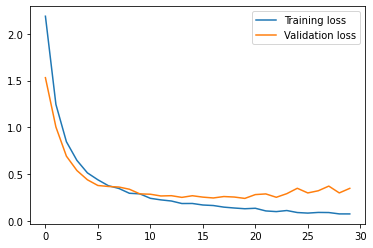

In [43]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

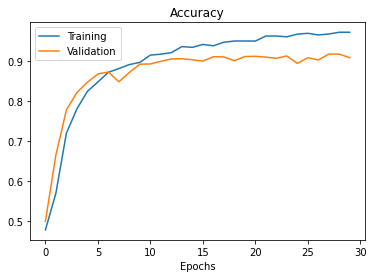

In [44]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### 8) Results
Given how similar accuracy, precision, and recall were for all of the models, I chose to compare accuracy between all of the models. The optimized CNN model ran quickly, prevented overfitting, and performed the best out of all of the models. Obviously, one would expect the CNN model to perform the best for image data, but seeing weaknesses of other models with image data was interesting.

<BarContainer object of 6 artists>

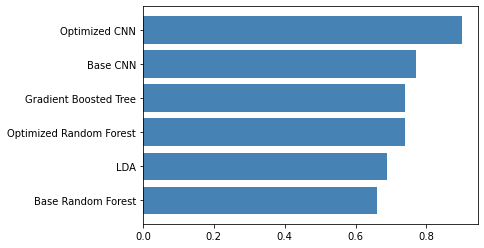

In [92]:
performance_df = pd.DataFrame({'model_name':['LDA','Base Random Forest','Optimized Random Forest','Gradient Boosted Tree','Base CNN','Optimized CNN'],'Accuracy':[0.69,0.66,0.74,0.74,0.77,0.90]})
df_sorted_desc= performance_df.sort_values('Accuracy',ascending=True)
plt.barh(df_sorted_desc.model_name,df_sorted_desc.Accuracy, color ='steelblue')